In [1]:
import pandas as pd
import numpy as np
from itertools import product
from scipy.stats import norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt

## IMPORTATION ET NETTOYAGE DES DONNES

In [2]:
# Charger le fichier Excel
df = pd.read_csv("data\credit_ratings\sectors_quater.csv")

# Afficher les premières lignes
df.head()

,year_quarter,obligor_name,rating_agency_name,rating,rating_action_date,legal_entity_identifier,year_month,year,pays,nace,next_rating
0,2022-07-01,"06 ENVIRONMENTAL, LLC",Egan-Jones Ratings Company,B,2022-07-22,NaN,2022-07-01,2022.0,NaN,RU,B
1,2021-07-01,"11065220 Canada, Inc.",Fitch Ratings,B,2021-08-18,549300ETSKJL315VDV79,2021-08-01,2021.0,NaN,RU,D
2,2019-04-01,"18 Fremont Street Acquisition, LLC",Moody's Investors Service,B,2019-06-06,5493000QK0X0K188BR60,2019-06-01,2019.0,US,RU,C
3,2019-07-01,"18 Fremont Street Acquisition, LLC",Moody's Investors Service,B,2019-07-01,5493000QK0X0K188BR60,2019-07-01,2019.0,US,RU,C
4,2019-10-01,"18 Fremont Street Acquisition, LLC",Moody's Investors Service,B,2019-10-01,5493000QK0X0K188BR60,2019-10-01,2019.0,US,RU,C


In [3]:
df["pays"].unique()

array([nan, 'US', 'GB', 'DE', 'CA', 'SE', 'CH', 'RU', 'IN', 'ID', 'ES',
       'FR', 'TW', 'JP', 'NO', 'NL', 'BR', 'AE', 'NZ', 'KY', 'IE', 'BE',
       'LU', 'IT', 'CO', 'DK', 'GI', 'AU', 'JE', 'AR', 'CL', 'CY', 'BM',
       'VN', 'MX', 'CN', 'HK', 'AT', 'PA', 'PH', 'ZA', 'PT', 'IL', 'MH',
       'NG', 'OM', 'RO', 'LC', 'TR', 'FI', 'SG', 'VG', 'MY', 'PE', 'MU',
       'BS', 'IS', 'PY', 'GE', 'GG', 'IM', 'TT', 'BG', 'PL', 'LR', 'CW',
       'GL', 'LK', 'CZ', 'SA'], dtype=object)

In [4]:
def clean_data_rating_corporate(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # 1) Dates
    df["rating_action_date"] = pd.to_datetime(df["rating_action_date"], errors="coerce")

    # year_month : souvent "YYYY-MM-01" en string -> datetime Month Start
    df["year_month"] = pd.to_datetime(df["year_month"], errors="coerce")

    # year_quater : souvent "YYYY-MM-01" en string -> datetime Month Start
    df["year_quarter"] = pd.to_datetime(df["year_quarter"], errors="coerce")


    # 2) Strings : trim
    for c in ["rating_agency_name", "rating", "legal_entity_identifier", "obligor_name", "pays", "nace"]:
        df[c] = df[c].astype("string").str.strip()


    # 4) Nettoyage secteur (NACE)
    # (Tu peux adapter selon ton codage : lettres, divisions, etc.)
    df["nace"] = df["nace"].str.upper()

    # 5) Nettoyage rating
    df["rating"] = df["rating"].str.upper()

    return df


def quick_diagnostics(df: pd.DataFrame):
    print("---- DIAGNOSTICS ----")
    print("Nb lignes:", len(df))
    print("Nb entreprises (obligor_name):", df["obligor_name"].nunique())
    print("Nb agences:", df["rating_agency_name"].nunique())
    print("Nb secteurs (nace):", df["nace"].nunique())
    print("Période year_month:", df["year_month"].min(), "->", df["year_month"].max())

    print("\nTop agences:")
    print(df["rating_agency_name"].value_counts().head(10))

    print("\nTop ratings:")
    print(df["rating"].value_counts().head(15))

    print("\nTop secteurs (nace):")
    print(df["nace"].value_counts().head(15))

In [5]:
df=clean_data_rating_corporate(df)

In [6]:
quick_diagnostics(df)

---- DIAGNOSTICS ----
Nb lignes: 179452
Nb entreprises (obligor_name): 10315
Nb agences: 5
Nb secteurs (nace): 18
Période year_month: 2010-07-01 00:00:00 -> 2023-06-01 00:00:00

Top agences:
rating_agency_name
Standard & Poor's Ratings Services    75834
Egan-Jones Ratings Company            51647
Moody's Investors Service             20419
Japan Credit Rating Agency,Ltd.       17994
Fitch Ratings                         13558
Name: count, dtype: Int64

Top ratings:
rating
BBB    46581
B      45296
A      36357
BB     35061
AAA     9495
C       6662
Name: count, dtype: Int64

Top secteurs (nace):
nace
C5    21796
RU    20063
KZ    19998
C3    18309
JZ    15628
LZ    13557
BZ    13410
HZ    11513
C1     8483
GZ     7864
OQ     7462
CH     4526
C2     4385
C4     3312
IZ     3118
Name: count, dtype: Int64


In [7]:

import pandas as pd
import numpy as np

# 1) Mapping économique (à adapter si C1..C5 sont connus chez toi)
ECON_GROUP_MAP = {
    # Primaires / énergie
    "AZ": "extraction_primaire",
    "BZ": "extraction_primaire",  # si présent

    # Industrie / construction / immobilier

    "FZ": "construction_immo",
    "LZ": "construction_immo",

    # Transport / info
    "JZ": "info-com",

    # Services marchands
    "GZ": "services",
    "IZ": "services",
    "HZ": "services",

    # Finance
    "KZ": "finance",

    # Non-marchands / public
    "OQ": "public",
    "RU": "public",

    # Services pro (souvent très cycliques mais “services”)
    "MN": "services_pro",

    # Cas C1..C5 (à défaut)
    "C1": "industrie",
    "C2": "industrie",
    "C3": "industrie",
    "C4": "industrie",
    "C5": "industrie",
    "CH": "industrie",  # tu avais G7 dans le dendrogramme
}


def add_econ_group(df_Z, sector_col="sector"):
    df = df_Z.copy()
    df["sector"] = df[sector_col].map(ECON_GROUP_MAP).fillna("Autres")
    return df


df_clean=add_econ_group(df, sector_col="nace")

In [37]:
eu=['GB', 'DE', 'SE', 'CH', 'RU', 'ES', 'FR', 'NO', 'NL', 
 'IE', 'BE', 'LU', 'IT', 'DK', 'GI', 'JE', 'CY', 
 'AT', 'PT', 'RO', 'TR', 'FI', 'IS', 'GE', 'GG', 
 'IM', 'BG', 'PL', 'GL', 'CZ']
df_eu=df_clean[df_clean['pays'].isin(eu)]
am=['US', 'CA', 'BR', 'KY', 'CO', 'AR', 'CL', 'BM', 
 'MX', 'PA', 'LC', 'VG', 'PE', 'BS', 'PY', 
 'TT', 'CW']
df_am=df_clean[df_clean['pays'].isin(am)]
autre=['IN', 'ID', 'TW', 'AE', 'NZ', 'VN', 
 'CN', 'HK', 'PH', 'ZA', 'IL', 'MH', 
 'NG', 'OM', 'SG', 'MY', 'MU', 'LK', 'SA']
df_autre=df_clean[df_clean['pays'].isin(autre)]
jp=["JP"]
df_jp=df_clean[df_clean['pays'].isin(jp)]

## MATRICE DE TRANSITION PAR SECTEUR

In [9]:
# Nombre total de transitions pour un secteur donné sur toute la période

def nb_transitions(data, sector_value="finance"):
    data_sector = data[data["sector"] == sector_value]

    transition_counts = (
        data_sector
        .groupby(["rating", "next_rating"])
        .size()
        .reset_index(name="n")
    )

    transition_matrix = transition_counts.pivot_table(
        index="rating",
        columns="next_rating",
        values="n",
        fill_value=0
    )

    ordre_indices = ["AAA", "A", "BBB", "BB", "B", "C"]
    ordre_colonnes = ["AAA", "A", "BBB", "BB", "B", "C", "D"]

    return transition_matrix.reindex(
        index=ordre_indices,
        columns=ordre_colonnes
    ).fillna(0)

In [10]:
transition_matrix_finance=nb_transitions(df_clean)

In [11]:
# Calcul de la matrice de transition TTC (Transition To Transition) pour un secteur donné sur toute la période
def calculate_migration_ttc(df_clean,sector="finance"):
    transition_matrix = nb_transitions(df_clean, sector_value=sector)
    row_sums = transition_matrix.sum(axis=1)
    migration_ttc = transition_matrix.div(row_sums, axis=0)

    return migration_ttc

In [13]:
migration_ttc_finance=calculate_migration_ttc(df_clean=df_eu, sector="finance")

In [14]:
   
# Creation d'un dataframe complet des transitions observées par secteur et par période (year_quarter) avec les probabilités de transition
from itertools import product
import pandas as pd

def create_complete_quaterly_migration_counts_by_sector(df, sector_col="sector"):
    ratings = ["AAA", "A", "BBB", "BB", "B", "C", "D"]

    # counts observés
    migrations_count = (
        df.groupby(["year_quarter", sector_col, "rating", "next_rating"])
          .size()
          .reset_index(name="count")
    )

    unique_periods = migrations_count["year_quarter"].unique()
    unique_sectors = migrations_count[sector_col].unique()

    # toutes les combinaisons (period x sector x rating x next_rating)
    all_combinations = pd.DataFrame(
        list(product(unique_periods, unique_sectors, ratings, ratings)),
        columns=["year_quarter", sector_col, "rating", "next_rating"]
    )

    migrations_complete = all_combinations.merge(
        migrations_count,
        on=["year_quarter", sector_col, "rating", "next_rating"],
        how="left"
    )

    # on ne modélise pas les transitions à partir de D
    migrations_complete = migrations_complete[migrations_complete["rating"] != "D"].copy()

    # remplissage + proba
    migrations_complete["count"] = migrations_complete["count"].fillna(0).astype(int)

    migrations_complete["total_count"] = (
        migrations_complete.groupby(["year_quarter", sector_col, "rating"])["count"]
        .transform("sum")
        .fillna(0)
        .astype(int)
    )

    migrations_complete["transition_prob"] = (
        migrations_complete["count"] / migrations_complete["total_count"]
    ).fillna(0)

    return migrations_complete

In [15]:
migrations_count_complete = create_complete_quaterly_migration_counts_by_sector(df_clean)

In [16]:
# Création de la matrice de transition PIT (Point In Time) par secteur et par période (year_quarter)
def create_matrice_PIT_by_sector(migrations_complete, sector_col="sector"):
    return migrations_complete.pivot_table(
        index=["year_quarter", sector_col, "rating"],
        columns="next_rating",
        values="transition_prob",
        fill_value=0,
    )

In [17]:
matrice_pit=create_matrice_PIT_by_sector(migrations_count_complete)

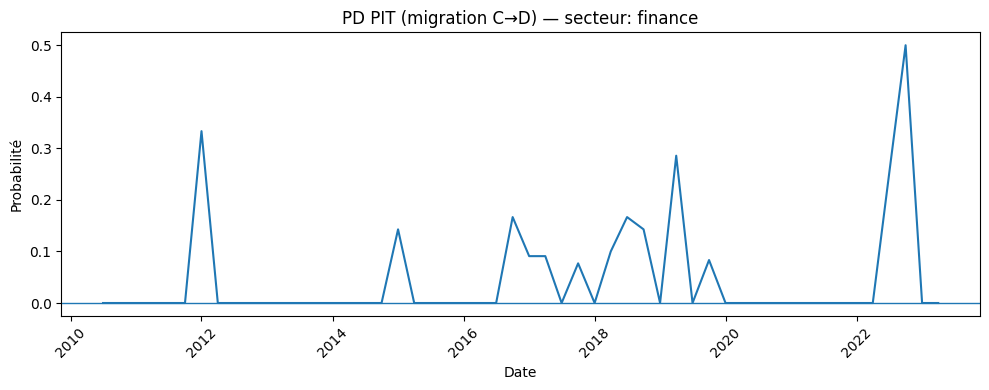

In [18]:
def plot_pd_pit_over_time(matrice_pit, sector, rating="BBB", default_col="D"):
    df_sec = matrice_pit.xs((sector, rating), level=("sector", "rating"))
    # df_sec index = year_quarter ; colonnes = next_rating
    if default_col not in df_sec.columns:
        raise ValueError(f"Colonne défaut '{default_col}' absente. Colonnes dispo: {list(df_sec.columns)}")

    s_pd = df_sec[default_col].sort_index()

    plt.figure(figsize=(10, 4))
    plt.plot(s_pd.index, s_pd.values)
    plt.axhline(0, linewidth=1)
    plt.title(f"PD PIT (migration {rating}→{default_col}) — secteur: {sector}")
    plt.xlabel("Date")
    plt.ylabel("Probabilité")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Exemple
plot_pd_pit_over_time(matrice_pit, sector="finance", rating="C")

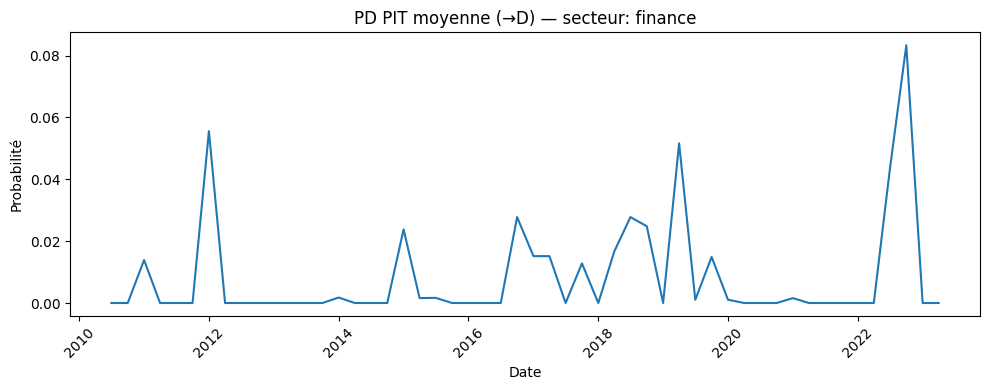

In [19]:
def plot_pd_pit_sector_average(matrice_pit, sector, default_col="D"):
    df_sec = matrice_pit.xs(sector, level="sector")  # index = (year_quarter, rating)
    if default_col not in df_sec.columns:
        raise ValueError(f"Colonne défaut '{default_col}' absente.")
    s = df_sec[default_col].groupby(level="year_quarter").mean().sort_index()

    plt.figure(figsize=(10, 4))
    plt.plot(s.index, s.values)
    plt.title(f"PD PIT moyenne (→{default_col}) — secteur: {sector}")
    plt.xlabel("Date")
    plt.ylabel("Probabilité")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Exemple
plot_pd_pit_sector_average(matrice_pit, "finance")

In [33]:
# Calcul de la matrice de barrières à partir de la matrice de transition TTC pour un secteur donné
def calculate_barrier_matrix(df_clean,sector="finance"):
    ttc_matrix=calculate_migration_ttc(df_clean, sector=sector)
    barrier_matrix = np.zeros_like(ttc_matrix, dtype=float)
    for idx, (i, row) in enumerate(ttc_matrix.iterrows()):
        cumulative_sum = 0
        for j in reversed(range(len(row))):
            cumulative_sum += row.iloc[j]
            barrier_matrix[idx, j] = norm.ppf(cumulative_sum)
    barrier_matrix_df = pd.DataFrame(barrier_matrix, index=ttc_matrix.index, columns=ttc_matrix.columns)
    return barrier_matrix_df

def calculate_rho(pd_series):
    value = (1 - np.exp(-50 * pd_series)) / (1 - np.exp(-50))
    return 0.12 * value + 0.24 * (1 - value)

In [25]:
barrier_matrix_df = calculate_barrier_matrix(df_eu,sector="finance")
rho_finance=calculate_rho(migration_ttc_finance["D"])

In [26]:
# Calcul des probabilités de transition PIT à partir de la matrice de barrières, du facteur systémique z_t et du rho
def calculate_pit_probabilities(z_t, barrier_matrix, rho):
    ratings = barrier_matrix.index
    next_ratings = barrier_matrix.columns
    pit_matrix = pd.DataFrame(index=ratings, columns=next_ratings, dtype=float)

    for i, rating in enumerate(ratings):
        rho_i = rho[rating]
        for j, next_rating in enumerate(next_ratings):
            if j == 0:
                b_next = barrier_matrix.loc[rating, next_ratings[j + 1]]
                numerator = b_next - np.sqrt(rho_i) * z_t
                probability = 1 - norm.cdf(numerator / np.sqrt(1 - rho_i))
            elif j == len(next_ratings) - 1:
                b = barrier_matrix.loc[rating, next_rating]
                probability = norm.cdf((b - np.sqrt(rho_i) * z_t) / np.sqrt(1 - rho_i))
            else:
                b = barrier_matrix.loc[rating, next_rating]
                b_next = barrier_matrix.loc[rating, next_ratings[j + 1]]
                term1 = norm.cdf((b - np.sqrt(rho_i) * z_t) / np.sqrt(1 - rho_i))
                term2 = norm.cdf((b_next - np.sqrt(rho_i) * z_t) / np.sqrt(1 - rho_i))
                probability = term1 - term2
            pit_matrix.loc[rating, next_rating] = probability
    return pit_matrix

In [27]:
# Calcul de la Mean Squared Error (MSE) globale et par rating->next_rating entre les probabilités de transition observées et recalculées
def mse(probability_migrations):
    """Calcule la Mean Squared Error globale et par rating->next_rating."""
    df = probability_migrations.copy()
    df["squared_error"] = (df["observed"] - df["recalculated"])**2

    # MSE global
    mse_global = df["squared_error"].mean()

    # MSE par rating -> next_rating
    mse_matrix = df.groupby(["rating", "next_rating"])["squared_error"].mean().unstack().fillna(0)

    return mse_global, mse_matrix

In [31]:
# Optimisation du facteur systémique z_t par secteur et par période (year_quarter) pour minimiser la MSE entre les probabilités de transition observées et recalculées
import numpy as np
import pandas as pd
from scipy.optimize import minimize

def optimize_by_sector(df_clean, date_level="year_quarter", sector_value="finance", sector_level="sector"):
    zt = {}
    all_probs = []

    migrations_complete = create_complete_quaterly_migration_counts_by_sector(df_clean)
    migration_pit = create_matrice_PIT_by_sector(migrations_complete, sector_col=sector_level)

    # --- filtre sur le secteur demandé si le niveau existe dans l'index ---
    if sector_level in migration_pit.index.names:
        try:
            migration_pit_sector = migration_pit.xs(sector_value, level=sector_level)
        except KeyError:
            # secteur absent
            zt_series = pd.Series(dtype=float, name="z_t")
            probability_migrations = pd.DataFrame()
            return zt_series, probability_migrations, np.nan, None
    else:
        migration_pit_sector = migration_pit

    # Paramètres cohérents avec le secteur calibré
    barrier_matrix = calculate_barrier_matrix(df_clean=df_clean, sector=sector_value)
    rho = calculate_rho(calculate_migration_ttc(df_clean=df_clean, sector=sector_value)["D"])

    dates = migration_pit_sector.index.get_level_values(date_level).unique()

    for t in dates:
        # Matrice PIT observée pour la date t (déjà filtrée au secteur)
        try:
            pit_obs = migration_pit_sector.xs(t, level=date_level).sort_index()
        except KeyError:
            continue

        if pit_obs is None or pit_obs.size == 0:
            continue

        def loss(z):
            pit_th = calculate_pit_probabilities(float(z[0]), barrier_matrix, rho).sort_index()

            # Aligne index ET colonnes pour éviter toute incohérence
            a_obs, a_th = pit_obs.align(pit_th, join="inner", axis=None)

            diff = a_obs.values - a_th.values
            return np.nansum(diff ** 2)

        res = minimize(loss, x0=np.array([0.0]), bounds=[(-5, 5)], method="L-BFGS-B")
        z_hat = float(res.x[0])

        # Stocke zt avec un index (sector, date) directement
        zt[(sector_value, t)] = z_hat

        pit_th_hat = calculate_pit_probabilities(z_hat, barrier_matrix, rho).sort_index()

        probs_df = pd.concat(
            [
                pit_obs.stack().rename("observed"),
                pit_th_hat.stack().rename("recalculated"),
            ],
            axis=1,
            join="inner",
        ).reset_index()

        probs_df[date_level] = t
        probs_df[sector_level] = sector_value
        all_probs.append(probs_df)

    # Série des Zt par (sector, date)
    zt_series = pd.Series(zt, name="z_t")
    if len(zt_series) > 0:
        zt_series.index = pd.MultiIndex.from_tuples(
            zt_series.index, names=[sector_level, date_level]
        )
        zt_series = zt_series.sort_index()
    else:
        zt_series = pd.Series(dtype=float, name="z_t")
        zt_series.index = pd.MultiIndex.from_tuples([], names=[sector_level, date_level])

    # Tableau des proba observées vs recalculées
    probability_migrations = pd.concat(all_probs, ignore_index=True) if all_probs else pd.DataFrame()
    if not probability_migrations.empty:
        probability_migrations = probability_migrations.set_index(
            [date_level, sector_level, "rating", "next_rating"]
        ).sort_index()
        mse_global, mse_matrix = mse(probability_migrations)
    else:
        mse_global, mse_matrix = np.nan, None

    return zt_series, probability_migrations, mse_global, mse_matrix

In [29]:
import os
import numpy as np
import pandas as pd

SECTORS_DEFAULT = [
    'public', 'info-com', 'industrie', 'finance', 'services',
    'services_pro', 'construction_immo', 'extraction_primaire'
]

def extract_zt_all_sectors_to_csv(
    df_clean: pd.DataFrame,
    sectors=SECTORS_DEFAULT,
    date_level: str = "year_quarter",
    sector_level: str = "sector",
    out_dir: str = ".",
    zt_filename: str = "zt_by_sector.csv",
    probs_filename: str = "pit_probs_observed_vs_recalculated.csv",
    mse_filename: str = "mse_by_sector.csv",
    save_probs: bool = True,
    save_mse: bool = True,
):
    """
    Lance optimize_by_sector pour chaque secteur, concatène les résultats,
    et sauvegarde en CSV:
      - zt_by_sector.csv : z_t par (sector, year_quarter)
      - pit_probs_observed_vs_recalculated.csv (optionnel)
      - mse_by_sector.csv (optionnel)
    """
    os.makedirs(out_dir, exist_ok=True)

    zt_list = []
    probs_list = []
    mse_rows = []

    for sec in sectors:
        zt_series, prob_df, mse_global, mse_matrix = optimize_by_sector(
            df_clean,
            date_level=date_level,
            sector_value=sec,
            sector_level=sector_level
        )

        # --- ZT ---
        if zt_series is not None and len(zt_series) > 0:
            zt_list.append(zt_series.rename("z_t").to_frame())
        else:
            # garde trace même si vide
            mse_rows.append({"sector": sec, "mse_global": np.nan, "n_zt": 0})
            continue

        # --- Probas obs vs recalc ---
        if save_probs and isinstance(prob_df, pd.DataFrame) and not prob_df.empty:
            # remet en colonnes pour écrire facilement en CSV
            probs_list.append(prob_df.reset_index())

        # --- MSE ---
        if save_mse:
            mse_rows.append({
                "sector": sec,
                "mse_global": float(mse_global) if mse_global is not None else np.nan,
                "n_zt": int(len(zt_series))
            })

    # ============ EXPORT ZT ============
    if zt_list:
        zt_all = pd.concat(zt_list).reset_index()
        zt_all.columns = [sector_level, date_level, "z_t"]
        zt_all = zt_all.sort_values([sector_level, date_level])

        zt_path = os.path.join(out_dir, zt_filename)
        zt_all.to_csv(zt_path, index=False)
    else:
        zt_all = pd.DataFrame(columns=[sector_level, date_level, "z_t"])
        zt_path = os.path.join(out_dir, zt_filename)
        zt_all.to_csv(zt_path, index=False)

    # ============ EXPORT PROBS (optionnel) ============
    probs_path = None
    if save_probs:
        probs_path = os.path.join(out_dir, probs_filename)
        if probs_list:
            probs_all = pd.concat(probs_list, ignore_index=True)
            probs_all.to_csv(probs_path, index=False)
        else:
            pd.DataFrame().to_csv(probs_path, index=False)

    # ============ EXPORT MSE (optionnel) ============
    mse_path = None
    if save_mse:
        mse_path = os.path.join(out_dir, mse_filename)
        mse_df = pd.DataFrame(mse_rows).sort_values("sector")
        mse_df.to_csv(mse_path, index=False)

    return {
        "zt": zt_all,
        "zt_csv": zt_path,
        "probs_csv": probs_path,
        "mse_csv": mse_path,
    }

In [34]:
zt_sector, probs_sector, mse_global_sector, mse_matrix_sector = optimize_by_sector(df_clean=df_eu, sector_value="finance")

In [39]:
result = extract_zt_all_sectors_to_csv(
    df_clean=df_jp,
    out_dir="zt_jp",
    save_probs=True,   # mets False si tu ne veux pas le gros fichier
    save_mse=True
)

print("ZT saved to:", result["zt_csv"])
print("Probs saved to:", result["probs_csv"])
print("MSE saved to:", result["mse_csv"])
result["zt"].head()

ZT saved to: zt_jp\zt_by_sector.csv
Probs saved to: zt_jp\pit_probs_observed_vs_recalculated.csv
MSE saved to: zt_jp\mse_by_sector.csv


,sector,year_quarter,z_t
312,construction_immo,2010-07-01,2.965820
313,construction_immo,2010-10-01,1.868407
314,construction_immo,2011-01-01,1.868407
315,construction_immo,2011-04-01,1.868407
316,construction_immo,2011-07-01,1.868407


In [ ]:
def plotting_zt(sector):
    zt_sector = optimize_by_sector(date_level="year_quarter", sector_level="sector", sector_value=sector)[0]
    plt.figure(figsize=(10, 4))
    zt_sector.plot(title=f"Facteur systémique Zt pour le secteur {sector}")
    plt.show()

def plot_transitions(probability_migrations, pairs):
    """
    Trace les courbes observed vs recalculated pour une ou plusieurs paires (rating, next_rating).

    Args:
        pairs (list of [rating, next_rating]): liste de couples.
                                            Exemple: [["BBB","BB"], ["A","BBB"]]
    """
    if probability_migrations is None:
        raise ValueError("Les probabilités n'ont pas encore été calculées. Lancez optimize() d'abord.")

    import matplotlib.pyplot as plt
    from itertools import cycle

    plt.figure(figsize=(10, 5))
    colors = cycle(plt.cm.tab10.colors)  # palette cyclique pour les couleurs

    for rating, next_rating in pairs:
        color = next(colors)
        subset = probability_migrations.xs(
            (rating, next_rating), level=("rating", "next_rating")
        )
        plt.plot(subset.index, subset["observed"], label=f"Observed {rating}->{next_rating}", color=color)
        plt.plot(subset.index, subset["recalculated"], linestyle="--", label=f"Recalculated {rating}->{next_rating}", color=color)

    plt.title("Probabilités Observed vs Recalculated")
    plt.xlabel("Date")
    plt.ylabel("Transition Probability")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


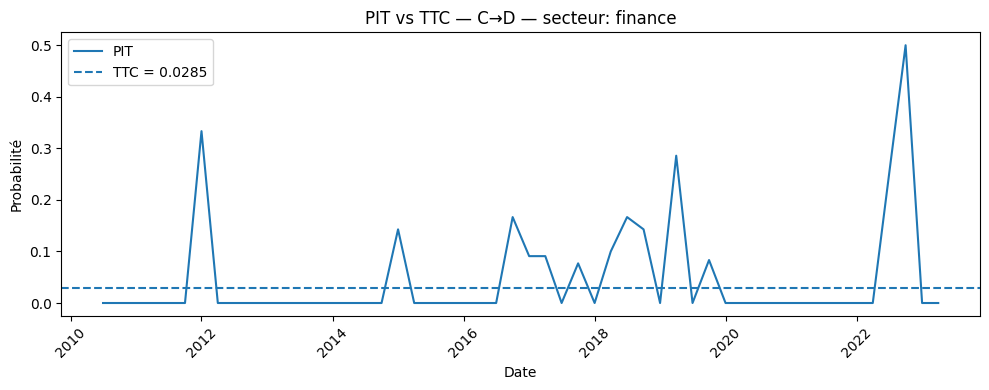

In [ ]:
def plot_pit_vs_ttc_default(matrice_pit, migration_ttc, sector, rating="BBB", default_col="D"):
    df_sec = matrice_pit.xs((sector, rating), level=("sector", "rating"))
    s_pit = df_sec[default_col].sort_index()

    p_ttc = float(migration_ttc.loc[rating, default_col])

    plt.figure(figsize=(10, 4))
    plt.plot(s_pit.index, s_pit.values, label="PIT")
    plt.axhline(p_ttc, linestyle="--", label=f"TTC = {p_ttc:.4f}")
    plt.title(f"PIT vs TTC — {rating}→{default_col} — secteur: {sector}")
    plt.xlabel("Date")
    plt.ylabel("Probabilité")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Exemple
plot_pit_vs_ttc_default(matrice_pit, migration_ttc_finance, "finance", rating="C")

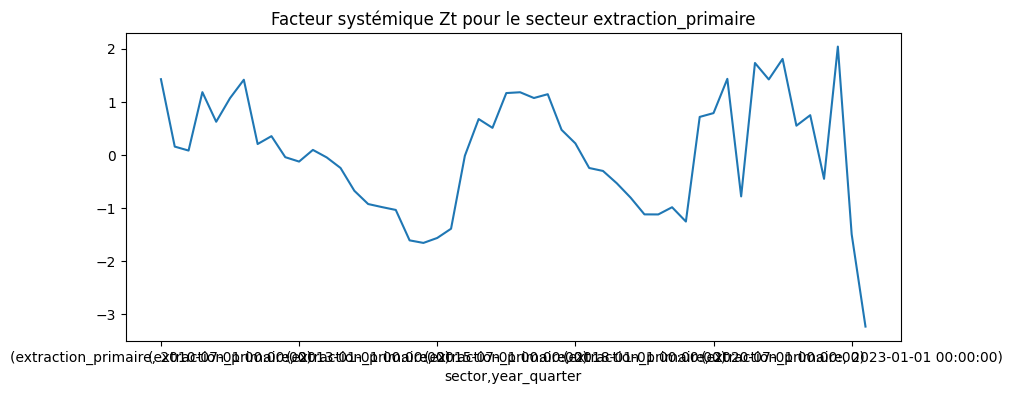

In [ ]:
plotting_zt("extraction_primaire")

In [ ]:
zt_finance= zt_series.loc["extraction_primaire"]

In [ ]:
zt_finance.to_csv("zt_extraction.csv")

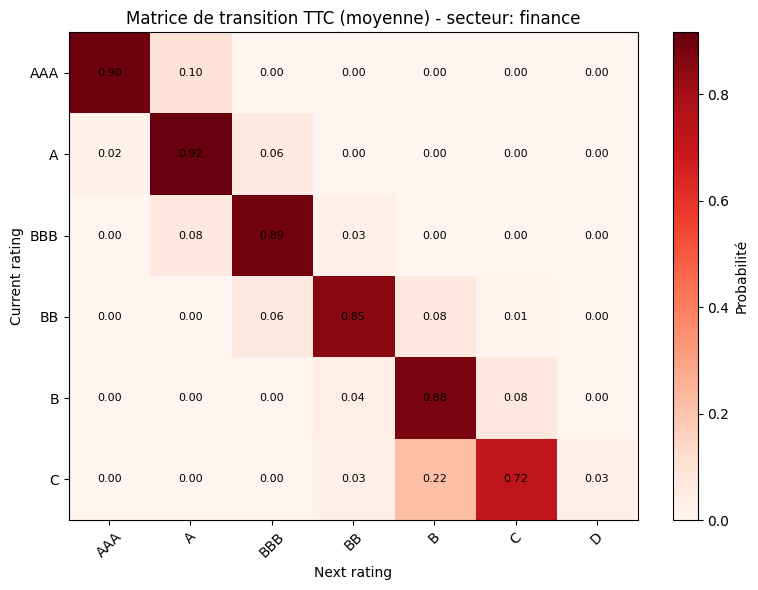

In [ ]:
def plot_ttc_heatmap(migration_ttc, 
                     title="Matrice de transition TTC (moyenne) - secteur: finance",
                     cmap="viridis"):   # colormap par défaut

    M = migration_ttc.values

    plt.figure(figsize=(8, 6))
    plt.imshow(M, aspect="auto", cmap=cmap)
    plt.title(title)
    plt.xlabel("Next rating")
    plt.ylabel("Current rating")
    plt.xticks(range(len(migration_ttc.columns)), migration_ttc.columns, rotation=45)
    plt.yticks(range(len(migration_ttc.index)), migration_ttc.index)

    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            plt.text(j, i, f"{M[i, j]:.2f}", ha="center", va="center", fontsize=8)

    plt.colorbar(label="Probabilité")
    plt.tight_layout()
    plt.show()

plot_ttc_heatmap(migration_ttc_finance, cmap="Reds")

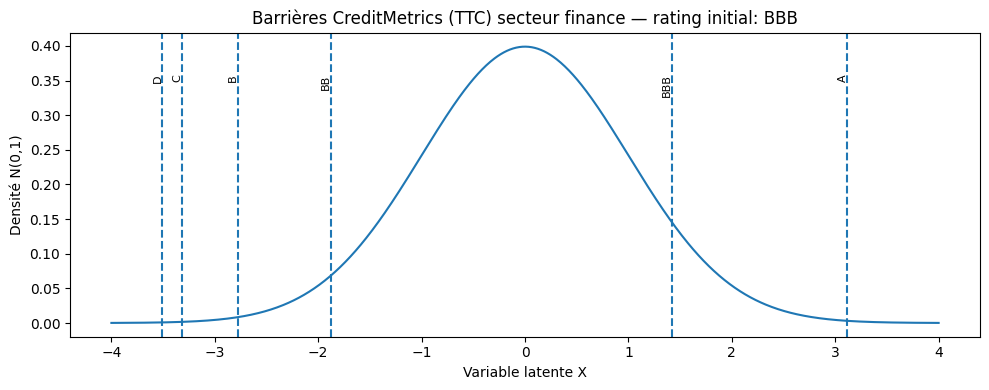

In [ ]:
def plot_barriers_normal(barrier_matrix_df, rating="BBB"):
    b = barrier_matrix_df.loc[rating].copy()

    # On ne garde que les valeurs finies et on les trie
    b = b[np.isfinite(b)].sort_values()

    x = np.linspace(-4, 4, 800)
    y = norm.pdf(x)

    plt.figure(figsize=(10, 4))
    plt.plot(x, y)
    for k, val in enumerate(b.values):
        plt.axvline(val, linestyle="--")
        plt.text(val, y.max()*0.9, b.index[k], rotation=90, va="top", ha="right", fontsize=8)

    plt.title(f"Barrières CreditMetrics (TTC) secteur finance — rating initial: {rating}")
    plt.xlabel("Variable latente X")
    plt.ylabel("Densité N(0,1)")
    plt.tight_layout()
    plt.show()

# Exemple
plot_barriers_normal(barrier_matrix_df, rating="BBB")

In [ ]:
barrier_matrix_df

next_rating,AAA,A,BBB,BB,B,C,D
rating,,,,,,,
AAA,inf,-1.274432,-2.636841,-2.805688,-2.805688,-inf,-inf
A,inf,2.009321,-1.542466,-2.881663,-3.405966,-3.590810,-inf
BBB,inf,3.118228,1.418601,-1.877163,-2.778666,-3.317057,-3.506023
BB,inf,inf,2.827795,1.504027,-1.376292,-2.491464,-inf
B,inf,inf,inf,2.698544,1.730325,-1.405844,-2.786645
C,8.209536,8.209536,8.209536,2.858587,1.883930,0.671146,-1.853367


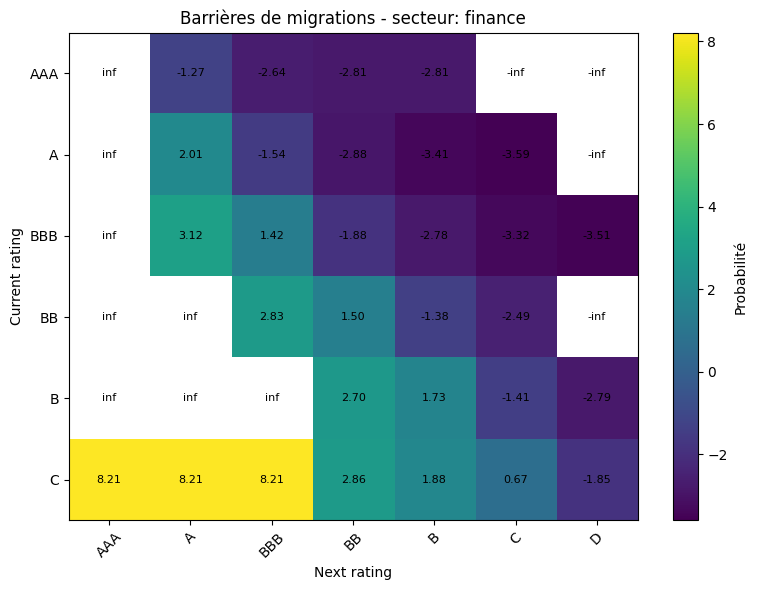

In [ ]:
def plot_barrier_heatmap(barrier_matrix_df, 
                     title="Barrières de migrations - secteur: finance",
                     cmap="viridis"):   # colormap par défaut

    M = barrier_matrix_df.values

    plt.figure(figsize=(8, 6))
    plt.imshow(M, aspect="auto", cmap=cmap)
    plt.title(title)
    plt.xlabel("Rating d'origine")
    plt.ylabel("Rating de destination")
    plt.xticks(range(len(barrier_matrix_df.columns)), barrier_matrix_df.columns, rotation=45)
    plt.yticks(range(len(barrier_matrix_df.index)), barrier_matrix_df.index)

    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            plt.text(j, i, f"{M[i, j]:.2f}", ha="center", va="center", fontsize=8)

    plt.colorbar(label="Probabilité")
    plt.tight_layout()
    plt.show()

plot_barrier_heatmap(barrier_matrix_df, cmap="viridis")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_barrier_heatmap_clip(matrix, title="Barrières de Migration", vmin=-20, vmax=20):
    data = matrix.copy()

    # Sauvegarde des positions inf avant remplacement
    vals = matrix.values
    posinf = np.isposinf(vals)
    neginf = np.isneginf(vals)

    # Remplacement pour la colormap (comme ton code)
    data = data.replace(np.inf, vmax).replace(-np.inf, vmin)

    # ----- Création des annotations personnalisées -----
    annot_labels = data.round(2).astype(str)

    for i in range(vals.shape[0]):
        for j in range(vals.shape[1]):
            if posinf[i, j]:
                annot_labels.iloc[i, j] = "+∞"
            elif neginf[i, j]:
                annot_labels.iloc[i, j] = "−∞"

    plt.figure(figsize=(9, 6))
    ax = sns.heatmap(
        data,
        annot=annot_labels,   # <- on passe nos labels custom
        fmt="",               # <- important : désactive fmt=".2f"
        cmap="coolwarm",
        center=0,
        vmin=vmin,
        vmax=vmax,
        linewidths=0.5,
        linecolor="white",
        cbar_kws={"label": r"Seuil de migration ($\Phi^{-1}$)"}
    )

    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Rating de destination")
    ax.set_ylabel("Rating d'origine")
    ax.tick_params(axis="x", rotation=0)
    ax.tick_params(axis="y", rotation=0)

    plt.tight_layout()
    plt.show()

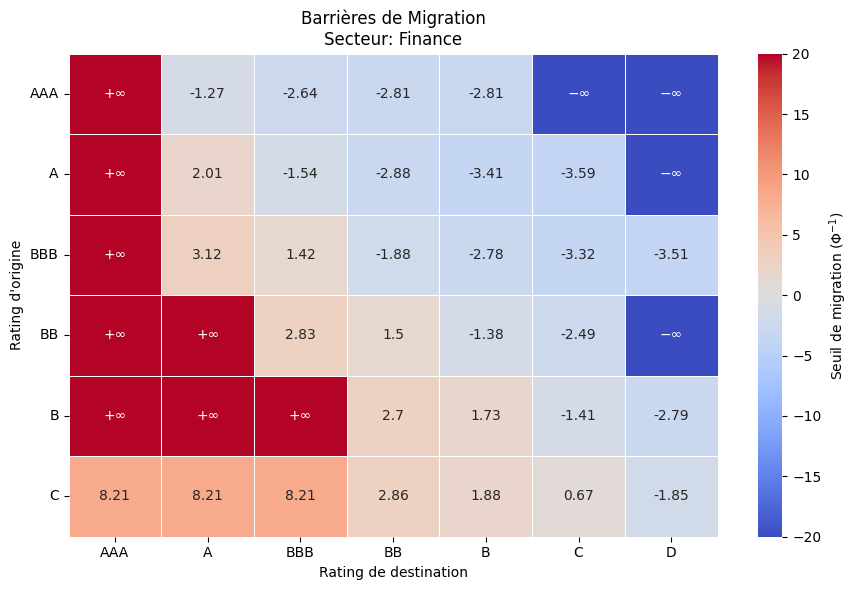

In [ ]:
plot_barrier_heatmap_clip(barrier_matrix_df, title="Barrières de Migration\nSecteur: Finance")

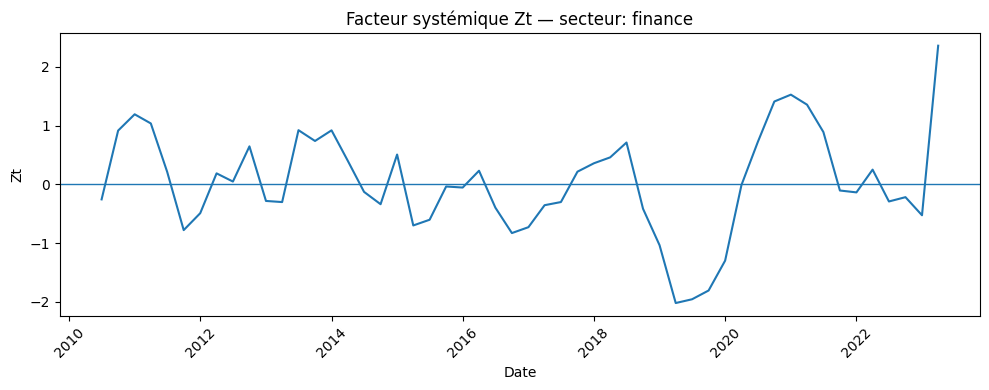

In [ ]:
zt_series = optimize_by_sector(date_level="year_quarter", sector_level="sector", sector_value="finance")[0]
def plot_zt_series(zt_series, sector):
    s = zt_series.xs(sector, level="sector").sort_index()

    plt.figure(figsize=(10, 4))
    plt.plot(s.index, s.values)
    plt.axhline(0, linewidth=1)
    plt.title(f"Facteur systémique Zt — secteur: {sector}")
    plt.xlabel("Date")
    plt.ylabel("Zt")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Exemple
plot_zt_series(zt_series, "finance")

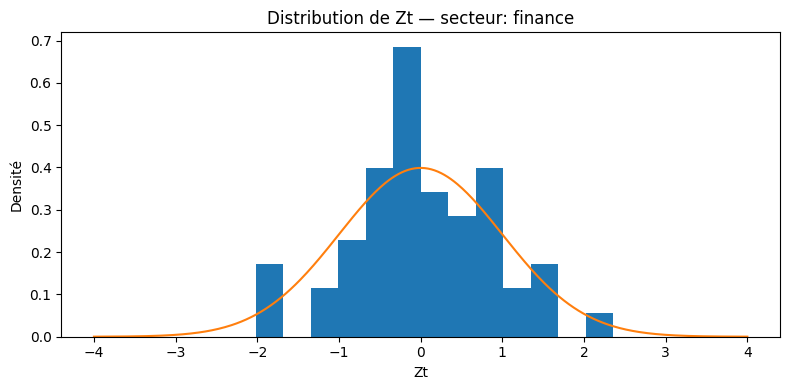

In [ ]:
def plot_zt_distribution_hist(zt_series, sector=None, bins=20):
    if sector is None:
        z = zt_series.values
        ttl = "Distribution de Zt (tous secteurs)"
    else:
        z = zt_series.xs(sector, level="sector").values
        ttl = f"Distribution de Zt — secteur: {sector}"

    z = np.asarray(z)
    z = z[np.isfinite(z)]

    plt.figure(figsize=(8, 4))
    plt.hist(z, bins=bins, density=True)
    x = np.linspace(min(z.min(), -4), max(z.max(), 4), 400)
    plt.plot(x, norm.pdf(x))
    plt.title(ttl)
    plt.xlabel("Zt")
    plt.ylabel("Densité")
    plt.tight_layout()
    plt.show()

# Exemple
plot_zt_distribution_hist(zt_series, sector="finance", bins=13)

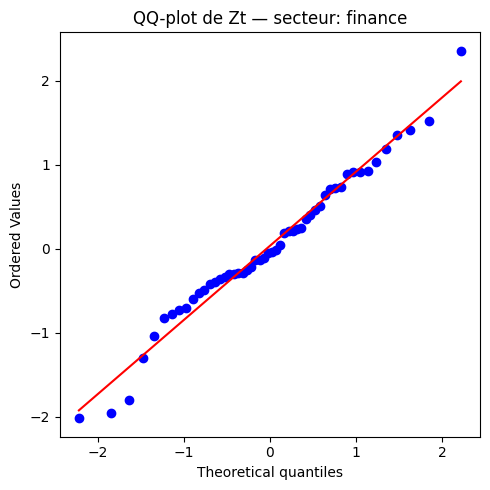

In [ ]:
from scipy.stats import  probplot
def plot_zt_qqplot(zt_series, sector=None):
    if sector is None:
        z = zt_series.values
        ttl = "QQ-plot de Zt (tous secteurs)"
    else:
        z = zt_series.xs(sector, level="sector").values
        ttl = f"QQ-plot de Zt — secteur: {sector}"

    z = np.asarray(z)
    z = z[np.isfinite(z)]

    plt.figure(figsize=(5, 5))
    probplot(z, dist="norm", plot=plt)
    plt.title(ttl)
    plt.tight_layout()
    plt.show()

# Exemple
plot_zt_qqplot(zt_series, sector="finance")

ConversionError: Failed to convert value(s) to axis units: array([(Timestamp('2010-07-01 00:00:00'), 'construction_immo'),
       (Timestamp('2010-07-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2010-07-01 00:00:00'), 'finance'),
       (Timestamp('2010-07-01 00:00:00'), 'industrie'),
       (Timestamp('2010-07-01 00:00:00'), 'info-com'),
       (Timestamp('2010-07-01 00:00:00'), 'public'),
       (Timestamp('2010-07-01 00:00:00'), 'services'),
       (Timestamp('2010-07-01 00:00:00'), 'services_pro'),
       (Timestamp('2010-10-01 00:00:00'), 'construction_immo'),
       (Timestamp('2010-10-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2010-10-01 00:00:00'), 'finance'),
       (Timestamp('2010-10-01 00:00:00'), 'industrie'),
       (Timestamp('2010-10-01 00:00:00'), 'info-com'),
       (Timestamp('2010-10-01 00:00:00'), 'public'),
       (Timestamp('2010-10-01 00:00:00'), 'services'),
       (Timestamp('2010-10-01 00:00:00'), 'services_pro'),
       (Timestamp('2011-01-01 00:00:00'), 'construction_immo'),
       (Timestamp('2011-01-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2011-01-01 00:00:00'), 'finance'),
       (Timestamp('2011-01-01 00:00:00'), 'industrie'),
       (Timestamp('2011-01-01 00:00:00'), 'info-com'),
       (Timestamp('2011-01-01 00:00:00'), 'public'),
       (Timestamp('2011-01-01 00:00:00'), 'services'),
       (Timestamp('2011-01-01 00:00:00'), 'services_pro'),
       (Timestamp('2011-04-01 00:00:00'), 'construction_immo'),
       (Timestamp('2011-04-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2011-04-01 00:00:00'), 'finance'),
       (Timestamp('2011-04-01 00:00:00'), 'industrie'),
       (Timestamp('2011-04-01 00:00:00'), 'info-com'),
       (Timestamp('2011-04-01 00:00:00'), 'public'),
       (Timestamp('2011-04-01 00:00:00'), 'services'),
       (Timestamp('2011-04-01 00:00:00'), 'services_pro'),
       (Timestamp('2011-07-01 00:00:00'), 'construction_immo'),
       (Timestamp('2011-07-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2011-07-01 00:00:00'), 'finance'),
       (Timestamp('2011-07-01 00:00:00'), 'industrie'),
       (Timestamp('2011-07-01 00:00:00'), 'info-com'),
       (Timestamp('2011-07-01 00:00:00'), 'public'),
       (Timestamp('2011-07-01 00:00:00'), 'services'),
       (Timestamp('2011-07-01 00:00:00'), 'services_pro'),
       (Timestamp('2011-10-01 00:00:00'), 'construction_immo'),
       (Timestamp('2011-10-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2011-10-01 00:00:00'), 'finance'),
       (Timestamp('2011-10-01 00:00:00'), 'industrie'),
       (Timestamp('2011-10-01 00:00:00'), 'info-com'),
       (Timestamp('2011-10-01 00:00:00'), 'public'),
       (Timestamp('2011-10-01 00:00:00'), 'services'),
       (Timestamp('2011-10-01 00:00:00'), 'services_pro'),
       (Timestamp('2012-01-01 00:00:00'), 'construction_immo'),
       (Timestamp('2012-01-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2012-01-01 00:00:00'), 'finance'),
       (Timestamp('2012-01-01 00:00:00'), 'industrie'),
       (Timestamp('2012-01-01 00:00:00'), 'info-com'),
       (Timestamp('2012-01-01 00:00:00'), 'public'),
       (Timestamp('2012-01-01 00:00:00'), 'services'),
       (Timestamp('2012-01-01 00:00:00'), 'services_pro'),
       (Timestamp('2012-04-01 00:00:00'), 'construction_immo'),
       (Timestamp('2012-04-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2012-04-01 00:00:00'), 'finance'),
       (Timestamp('2012-04-01 00:00:00'), 'industrie'),
       (Timestamp('2012-04-01 00:00:00'), 'info-com'),
       (Timestamp('2012-04-01 00:00:00'), 'public'),
       (Timestamp('2012-04-01 00:00:00'), 'services'),
       (Timestamp('2012-04-01 00:00:00'), 'services_pro'),
       (Timestamp('2012-07-01 00:00:00'), 'construction_immo'),
       (Timestamp('2012-07-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2012-07-01 00:00:00'), 'finance'),
       (Timestamp('2012-07-01 00:00:00'), 'industrie'),
       (Timestamp('2012-07-01 00:00:00'), 'info-com'),
       (Timestamp('2012-07-01 00:00:00'), 'public'),
       (Timestamp('2012-07-01 00:00:00'), 'services'),
       (Timestamp('2012-07-01 00:00:00'), 'services_pro'),
       (Timestamp('2012-10-01 00:00:00'), 'construction_immo'),
       (Timestamp('2012-10-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2012-10-01 00:00:00'), 'finance'),
       (Timestamp('2012-10-01 00:00:00'), 'industrie'),
       (Timestamp('2012-10-01 00:00:00'), 'info-com'),
       (Timestamp('2012-10-01 00:00:00'), 'public'),
       (Timestamp('2012-10-01 00:00:00'), 'services'),
       (Timestamp('2012-10-01 00:00:00'), 'services_pro'),
       (Timestamp('2013-01-01 00:00:00'), 'construction_immo'),
       (Timestamp('2013-01-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2013-01-01 00:00:00'), 'finance'),
       (Timestamp('2013-01-01 00:00:00'), 'industrie'),
       (Timestamp('2013-01-01 00:00:00'), 'info-com'),
       (Timestamp('2013-01-01 00:00:00'), 'public'),
       (Timestamp('2013-01-01 00:00:00'), 'services'),
       (Timestamp('2013-01-01 00:00:00'), 'services_pro'),
       (Timestamp('2013-04-01 00:00:00'), 'construction_immo'),
       (Timestamp('2013-04-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2013-04-01 00:00:00'), 'finance'),
       (Timestamp('2013-04-01 00:00:00'), 'industrie'),
       (Timestamp('2013-04-01 00:00:00'), 'info-com'),
       (Timestamp('2013-04-01 00:00:00'), 'public'),
       (Timestamp('2013-04-01 00:00:00'), 'services'),
       (Timestamp('2013-04-01 00:00:00'), 'services_pro'),
       (Timestamp('2013-07-01 00:00:00'), 'construction_immo'),
       (Timestamp('2013-07-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2013-07-01 00:00:00'), 'finance'),
       (Timestamp('2013-07-01 00:00:00'), 'industrie'),
       (Timestamp('2013-07-01 00:00:00'), 'info-com'),
       (Timestamp('2013-07-01 00:00:00'), 'public'),
       (Timestamp('2013-07-01 00:00:00'), 'services'),
       (Timestamp('2013-07-01 00:00:00'), 'services_pro'),
       (Timestamp('2013-10-01 00:00:00'), 'construction_immo'),
       (Timestamp('2013-10-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2013-10-01 00:00:00'), 'finance'),
       (Timestamp('2013-10-01 00:00:00'), 'industrie'),
       (Timestamp('2013-10-01 00:00:00'), 'info-com'),
       (Timestamp('2013-10-01 00:00:00'), 'public'),
       (Timestamp('2013-10-01 00:00:00'), 'services'),
       (Timestamp('2013-10-01 00:00:00'), 'services_pro'),
       (Timestamp('2014-01-01 00:00:00'), 'construction_immo'),
       (Timestamp('2014-01-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2014-01-01 00:00:00'), 'finance'),
       (Timestamp('2014-01-01 00:00:00'), 'industrie'),
       (Timestamp('2014-01-01 00:00:00'), 'info-com'),
       (Timestamp('2014-01-01 00:00:00'), 'public'),
       (Timestamp('2014-01-01 00:00:00'), 'services'),
       (Timestamp('2014-01-01 00:00:00'), 'services_pro'),
       (Timestamp('2014-04-01 00:00:00'), 'construction_immo'),
       (Timestamp('2014-04-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2014-04-01 00:00:00'), 'finance'),
       (Timestamp('2014-04-01 00:00:00'), 'industrie'),
       (Timestamp('2014-04-01 00:00:00'), 'info-com'),
       (Timestamp('2014-04-01 00:00:00'), 'public'),
       (Timestamp('2014-04-01 00:00:00'), 'services'),
       (Timestamp('2014-04-01 00:00:00'), 'services_pro'),
       (Timestamp('2014-07-01 00:00:00'), 'construction_immo'),
       (Timestamp('2014-07-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2014-07-01 00:00:00'), 'finance'),
       (Timestamp('2014-07-01 00:00:00'), 'industrie'),
       (Timestamp('2014-07-01 00:00:00'), 'info-com'),
       (Timestamp('2014-07-01 00:00:00'), 'public'),
       (Timestamp('2014-07-01 00:00:00'), 'services'),
       (Timestamp('2014-07-01 00:00:00'), 'services_pro'),
       (Timestamp('2014-10-01 00:00:00'), 'construction_immo'),
       (Timestamp('2014-10-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2014-10-01 00:00:00'), 'finance'),
       (Timestamp('2014-10-01 00:00:00'), 'industrie'),
       (Timestamp('2014-10-01 00:00:00'), 'info-com'),
       (Timestamp('2014-10-01 00:00:00'), 'public'),
       (Timestamp('2014-10-01 00:00:00'), 'services'),
       (Timestamp('2014-10-01 00:00:00'), 'services_pro'),
       (Timestamp('2015-01-01 00:00:00'), 'construction_immo'),
       (Timestamp('2015-01-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2015-01-01 00:00:00'), 'finance'),
       (Timestamp('2015-01-01 00:00:00'), 'industrie'),
       (Timestamp('2015-01-01 00:00:00'), 'info-com'),
       (Timestamp('2015-01-01 00:00:00'), 'public'),
       (Timestamp('2015-01-01 00:00:00'), 'services'),
       (Timestamp('2015-01-01 00:00:00'), 'services_pro'),
       (Timestamp('2015-04-01 00:00:00'), 'construction_immo'),
       (Timestamp('2015-04-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2015-04-01 00:00:00'), 'finance'),
       (Timestamp('2015-04-01 00:00:00'), 'industrie'),
       (Timestamp('2015-04-01 00:00:00'), 'info-com'),
       (Timestamp('2015-04-01 00:00:00'), 'public'),
       (Timestamp('2015-04-01 00:00:00'), 'services'),
       (Timestamp('2015-04-01 00:00:00'), 'services_pro'),
       (Timestamp('2015-07-01 00:00:00'), 'construction_immo'),
       (Timestamp('2015-07-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2015-07-01 00:00:00'), 'finance'),
       (Timestamp('2015-07-01 00:00:00'), 'industrie'),
       (Timestamp('2015-07-01 00:00:00'), 'info-com'),
       (Timestamp('2015-07-01 00:00:00'), 'public'),
       (Timestamp('2015-07-01 00:00:00'), 'services'),
       (Timestamp('2015-07-01 00:00:00'), 'services_pro'),
       (Timestamp('2015-10-01 00:00:00'), 'construction_immo'),
       (Timestamp('2015-10-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2015-10-01 00:00:00'), 'finance'),
       (Timestamp('2015-10-01 00:00:00'), 'industrie'),
       (Timestamp('2015-10-01 00:00:00'), 'info-com'),
       (Timestamp('2015-10-01 00:00:00'), 'public'),
       (Timestamp('2015-10-01 00:00:00'), 'services'),
       (Timestamp('2015-10-01 00:00:00'), 'services_pro'),
       (Timestamp('2016-01-01 00:00:00'), 'construction_immo'),
       (Timestamp('2016-01-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2016-01-01 00:00:00'), 'finance'),
       (Timestamp('2016-01-01 00:00:00'), 'industrie'),
       (Timestamp('2016-01-01 00:00:00'), 'info-com'),
       (Timestamp('2016-01-01 00:00:00'), 'public'),
       (Timestamp('2016-01-01 00:00:00'), 'services'),
       (Timestamp('2016-01-01 00:00:00'), 'services_pro'),
       (Timestamp('2016-04-01 00:00:00'), 'construction_immo'),
       (Timestamp('2016-04-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2016-04-01 00:00:00'), 'finance'),
       (Timestamp('2016-04-01 00:00:00'), 'industrie'),
       (Timestamp('2016-04-01 00:00:00'), 'info-com'),
       (Timestamp('2016-04-01 00:00:00'), 'public'),
       (Timestamp('2016-04-01 00:00:00'), 'services'),
       (Timestamp('2016-04-01 00:00:00'), 'services_pro'),
       (Timestamp('2016-07-01 00:00:00'), 'construction_immo'),
       (Timestamp('2016-07-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2016-07-01 00:00:00'), 'finance'),
       (Timestamp('2016-07-01 00:00:00'), 'industrie'),
       (Timestamp('2016-07-01 00:00:00'), 'info-com'),
       (Timestamp('2016-07-01 00:00:00'), 'public'),
       (Timestamp('2016-07-01 00:00:00'), 'services'),
       (Timestamp('2016-07-01 00:00:00'), 'services_pro'),
       (Timestamp('2016-10-01 00:00:00'), 'construction_immo'),
       (Timestamp('2016-10-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2016-10-01 00:00:00'), 'finance'),
       (Timestamp('2016-10-01 00:00:00'), 'industrie'),
       (Timestamp('2016-10-01 00:00:00'), 'info-com'),
       (Timestamp('2016-10-01 00:00:00'), 'public'),
       (Timestamp('2016-10-01 00:00:00'), 'services'),
       (Timestamp('2016-10-01 00:00:00'), 'services_pro'),
       (Timestamp('2017-01-01 00:00:00'), 'construction_immo'),
       (Timestamp('2017-01-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2017-01-01 00:00:00'), 'finance'),
       (Timestamp('2017-01-01 00:00:00'), 'industrie'),
       (Timestamp('2017-01-01 00:00:00'), 'info-com'),
       (Timestamp('2017-01-01 00:00:00'), 'public'),
       (Timestamp('2017-01-01 00:00:00'), 'services'),
       (Timestamp('2017-01-01 00:00:00'), 'services_pro'),
       (Timestamp('2017-04-01 00:00:00'), 'construction_immo'),
       (Timestamp('2017-04-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2017-04-01 00:00:00'), 'finance'),
       (Timestamp('2017-04-01 00:00:00'), 'industrie'),
       (Timestamp('2017-04-01 00:00:00'), 'info-com'),
       (Timestamp('2017-04-01 00:00:00'), 'public'),
       (Timestamp('2017-04-01 00:00:00'), 'services'),
       (Timestamp('2017-04-01 00:00:00'), 'services_pro'),
       (Timestamp('2017-07-01 00:00:00'), 'construction_immo'),
       (Timestamp('2017-07-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2017-07-01 00:00:00'), 'finance'),
       (Timestamp('2017-07-01 00:00:00'), 'industrie'),
       (Timestamp('2017-07-01 00:00:00'), 'info-com'),
       (Timestamp('2017-07-01 00:00:00'), 'public'),
       (Timestamp('2017-07-01 00:00:00'), 'services'),
       (Timestamp('2017-07-01 00:00:00'), 'services_pro'),
       (Timestamp('2017-10-01 00:00:00'), 'construction_immo'),
       (Timestamp('2017-10-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2017-10-01 00:00:00'), 'finance'),
       (Timestamp('2017-10-01 00:00:00'), 'industrie'),
       (Timestamp('2017-10-01 00:00:00'), 'info-com'),
       (Timestamp('2017-10-01 00:00:00'), 'public'),
       (Timestamp('2017-10-01 00:00:00'), 'services'),
       (Timestamp('2017-10-01 00:00:00'), 'services_pro'),
       (Timestamp('2018-01-01 00:00:00'), 'construction_immo'),
       (Timestamp('2018-01-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2018-01-01 00:00:00'), 'finance'),
       (Timestamp('2018-01-01 00:00:00'), 'industrie'),
       (Timestamp('2018-01-01 00:00:00'), 'info-com'),
       (Timestamp('2018-01-01 00:00:00'), 'public'),
       (Timestamp('2018-01-01 00:00:00'), 'services'),
       (Timestamp('2018-01-01 00:00:00'), 'services_pro'),
       (Timestamp('2018-04-01 00:00:00'), 'construction_immo'),
       (Timestamp('2018-04-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2018-04-01 00:00:00'), 'finance'),
       (Timestamp('2018-04-01 00:00:00'), 'industrie'),
       (Timestamp('2018-04-01 00:00:00'), 'info-com'),
       (Timestamp('2018-04-01 00:00:00'), 'public'),
       (Timestamp('2018-04-01 00:00:00'), 'services'),
       (Timestamp('2018-04-01 00:00:00'), 'services_pro'),
       (Timestamp('2018-07-01 00:00:00'), 'construction_immo'),
       (Timestamp('2018-07-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2018-07-01 00:00:00'), 'finance'),
       (Timestamp('2018-07-01 00:00:00'), 'industrie'),
       (Timestamp('2018-07-01 00:00:00'), 'info-com'),
       (Timestamp('2018-07-01 00:00:00'), 'public'),
       (Timestamp('2018-07-01 00:00:00'), 'services'),
       (Timestamp('2018-07-01 00:00:00'), 'services_pro'),
       (Timestamp('2018-10-01 00:00:00'), 'construction_immo'),
       (Timestamp('2018-10-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2018-10-01 00:00:00'), 'finance'),
       (Timestamp('2018-10-01 00:00:00'), 'industrie'),
       (Timestamp('2018-10-01 00:00:00'), 'info-com'),
       (Timestamp('2018-10-01 00:00:00'), 'public'),
       (Timestamp('2018-10-01 00:00:00'), 'services'),
       (Timestamp('2018-10-01 00:00:00'), 'services_pro'),
       (Timestamp('2019-01-01 00:00:00'), 'construction_immo'),
       (Timestamp('2019-01-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2019-01-01 00:00:00'), 'finance'),
       (Timestamp('2019-01-01 00:00:00'), 'industrie'),
       (Timestamp('2019-01-01 00:00:00'), 'info-com'),
       (Timestamp('2019-01-01 00:00:00'), 'public'),
       (Timestamp('2019-01-01 00:00:00'), 'services'),
       (Timestamp('2019-01-01 00:00:00'), 'services_pro'),
       (Timestamp('2019-04-01 00:00:00'), 'construction_immo'),
       (Timestamp('2019-04-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2019-04-01 00:00:00'), 'finance'),
       (Timestamp('2019-04-01 00:00:00'), 'industrie'),
       (Timestamp('2019-04-01 00:00:00'), 'info-com'),
       (Timestamp('2019-04-01 00:00:00'), 'public'),
       (Timestamp('2019-04-01 00:00:00'), 'services'),
       (Timestamp('2019-04-01 00:00:00'), 'services_pro'),
       (Timestamp('2019-07-01 00:00:00'), 'construction_immo'),
       (Timestamp('2019-07-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2019-07-01 00:00:00'), 'finance'),
       (Timestamp('2019-07-01 00:00:00'), 'industrie'),
       (Timestamp('2019-07-01 00:00:00'), 'info-com'),
       (Timestamp('2019-07-01 00:00:00'), 'public'),
       (Timestamp('2019-07-01 00:00:00'), 'services'),
       (Timestamp('2019-07-01 00:00:00'), 'services_pro'),
       (Timestamp('2019-10-01 00:00:00'), 'construction_immo'),
       (Timestamp('2019-10-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2019-10-01 00:00:00'), 'finance'),
       (Timestamp('2019-10-01 00:00:00'), 'industrie'),
       (Timestamp('2019-10-01 00:00:00'), 'info-com'),
       (Timestamp('2019-10-01 00:00:00'), 'public'),
       (Timestamp('2019-10-01 00:00:00'), 'services'),
       (Timestamp('2019-10-01 00:00:00'), 'services_pro'),
       (Timestamp('2020-01-01 00:00:00'), 'construction_immo'),
       (Timestamp('2020-01-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2020-01-01 00:00:00'), 'finance'),
       (Timestamp('2020-01-01 00:00:00'), 'industrie'),
       (Timestamp('2020-01-01 00:00:00'), 'info-com'),
       (Timestamp('2020-01-01 00:00:00'), 'public'),
       (Timestamp('2020-01-01 00:00:00'), 'services'),
       (Timestamp('2020-01-01 00:00:00'), 'services_pro'),
       (Timestamp('2020-04-01 00:00:00'), 'construction_immo'),
       (Timestamp('2020-04-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2020-04-01 00:00:00'), 'finance'),
       (Timestamp('2020-04-01 00:00:00'), 'industrie'),
       (Timestamp('2020-04-01 00:00:00'), 'info-com'),
       (Timestamp('2020-04-01 00:00:00'), 'public'),
       (Timestamp('2020-04-01 00:00:00'), 'services'),
       (Timestamp('2020-04-01 00:00:00'), 'services_pro'),
       (Timestamp('2020-07-01 00:00:00'), 'construction_immo'),
       (Timestamp('2020-07-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2020-07-01 00:00:00'), 'finance'),
       (Timestamp('2020-07-01 00:00:00'), 'industrie'),
       (Timestamp('2020-07-01 00:00:00'), 'info-com'),
       (Timestamp('2020-07-01 00:00:00'), 'public'),
       (Timestamp('2020-07-01 00:00:00'), 'services'),
       (Timestamp('2020-07-01 00:00:00'), 'services_pro'),
       (Timestamp('2020-10-01 00:00:00'), 'construction_immo'),
       (Timestamp('2020-10-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2020-10-01 00:00:00'), 'finance'),
       (Timestamp('2020-10-01 00:00:00'), 'industrie'),
       (Timestamp('2020-10-01 00:00:00'), 'info-com'),
       (Timestamp('2020-10-01 00:00:00'), 'public'),
       (Timestamp('2020-10-01 00:00:00'), 'services'),
       (Timestamp('2020-10-01 00:00:00'), 'services_pro'),
       (Timestamp('2021-01-01 00:00:00'), 'construction_immo'),
       (Timestamp('2021-01-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2021-01-01 00:00:00'), 'finance'),
       (Timestamp('2021-01-01 00:00:00'), 'industrie'),
       (Timestamp('2021-01-01 00:00:00'), 'info-com'),
       (Timestamp('2021-01-01 00:00:00'), 'public'),
       (Timestamp('2021-01-01 00:00:00'), 'services'),
       (Timestamp('2021-01-01 00:00:00'), 'services_pro'),
       (Timestamp('2021-04-01 00:00:00'), 'construction_immo'),
       (Timestamp('2021-04-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2021-04-01 00:00:00'), 'finance'),
       (Timestamp('2021-04-01 00:00:00'), 'industrie'),
       (Timestamp('2021-04-01 00:00:00'), 'info-com'),
       (Timestamp('2021-04-01 00:00:00'), 'public'),
       (Timestamp('2021-04-01 00:00:00'), 'services'),
       (Timestamp('2021-04-01 00:00:00'), 'services_pro'),
       (Timestamp('2021-07-01 00:00:00'), 'construction_immo'),
       (Timestamp('2021-07-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2021-07-01 00:00:00'), 'finance'),
       (Timestamp('2021-07-01 00:00:00'), 'industrie'),
       (Timestamp('2021-07-01 00:00:00'), 'info-com'),
       (Timestamp('2021-07-01 00:00:00'), 'public'),
       (Timestamp('2021-07-01 00:00:00'), 'services'),
       (Timestamp('2021-07-01 00:00:00'), 'services_pro'),
       (Timestamp('2021-10-01 00:00:00'), 'construction_immo'),
       (Timestamp('2021-10-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2021-10-01 00:00:00'), 'finance'),
       (Timestamp('2021-10-01 00:00:00'), 'industrie'),
       (Timestamp('2021-10-01 00:00:00'), 'info-com'),
       (Timestamp('2021-10-01 00:00:00'), 'public'),
       (Timestamp('2021-10-01 00:00:00'), 'services'),
       (Timestamp('2021-10-01 00:00:00'), 'services_pro'),
       (Timestamp('2022-01-01 00:00:00'), 'construction_immo'),
       (Timestamp('2022-01-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2022-01-01 00:00:00'), 'finance'),
       (Timestamp('2022-01-01 00:00:00'), 'industrie'),
       (Timestamp('2022-01-01 00:00:00'), 'info-com'),
       (Timestamp('2022-01-01 00:00:00'), 'public'),
       (Timestamp('2022-01-01 00:00:00'), 'services'),
       (Timestamp('2022-01-01 00:00:00'), 'services_pro'),
       (Timestamp('2022-04-01 00:00:00'), 'construction_immo'),
       (Timestamp('2022-04-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2022-04-01 00:00:00'), 'finance'),
       (Timestamp('2022-04-01 00:00:00'), 'industrie'),
       (Timestamp('2022-04-01 00:00:00'), 'info-com'),
       (Timestamp('2022-04-01 00:00:00'), 'public'),
       (Timestamp('2022-04-01 00:00:00'), 'services'),
       (Timestamp('2022-04-01 00:00:00'), 'services_pro'),
       (Timestamp('2022-07-01 00:00:00'), 'construction_immo'),
       (Timestamp('2022-07-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2022-07-01 00:00:00'), 'finance'),
       (Timestamp('2022-07-01 00:00:00'), 'industrie'),
       (Timestamp('2022-07-01 00:00:00'), 'info-com'),
       (Timestamp('2022-07-01 00:00:00'), 'public'),
       (Timestamp('2022-07-01 00:00:00'), 'services'),
       (Timestamp('2022-07-01 00:00:00'), 'services_pro'),
       (Timestamp('2022-10-01 00:00:00'), 'construction_immo'),
       (Timestamp('2022-10-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2022-10-01 00:00:00'), 'finance'),
       (Timestamp('2022-10-01 00:00:00'), 'industrie'),
       (Timestamp('2022-10-01 00:00:00'), 'info-com'),
       (Timestamp('2022-10-01 00:00:00'), 'public'),
       (Timestamp('2022-10-01 00:00:00'), 'services'),
       (Timestamp('2022-10-01 00:00:00'), 'services_pro'),
       (Timestamp('2023-01-01 00:00:00'), 'construction_immo'),
       (Timestamp('2023-01-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2023-01-01 00:00:00'), 'finance'),
       (Timestamp('2023-01-01 00:00:00'), 'industrie'),
       (Timestamp('2023-01-01 00:00:00'), 'info-com'),
       (Timestamp('2023-01-01 00:00:00'), 'public'),
       (Timestamp('2023-01-01 00:00:00'), 'services'),
       (Timestamp('2023-01-01 00:00:00'), 'services_pro'),
       (Timestamp('2023-04-01 00:00:00'), 'construction_immo'),
       (Timestamp('2023-04-01 00:00:00'), 'extraction_primaire'),
       (Timestamp('2023-04-01 00:00:00'), 'finance'),
       (Timestamp('2023-04-01 00:00:00'), 'industrie'),
       (Timestamp('2023-04-01 00:00:00'), 'info-com'),
       (Timestamp('2023-04-01 00:00:00'), 'public'),
       (Timestamp('2023-04-01 00:00:00'), 'services'),
       (Timestamp('2023-04-01 00:00:00'), 'services_pro')], dtype=object)

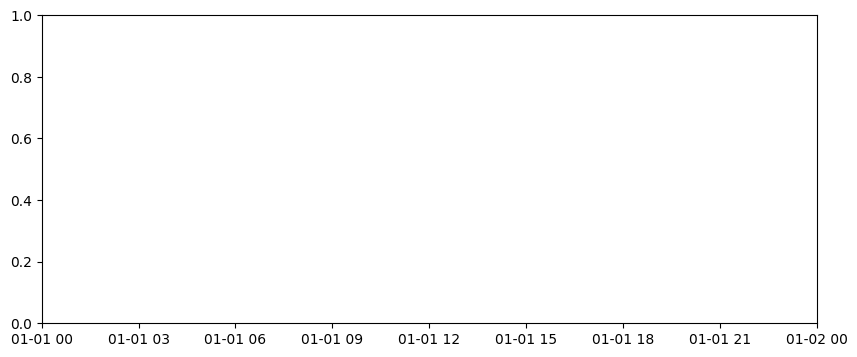

In [ ]:
def plot_pd_pit_over_time(matrice_pit, sector, rating="BBB", default_col="D"):
    df_sec = matrice_pit.xs(rating, level="rating")
    # df_sec index = year_quarter ; colonnes = next_rating
    if default_col not in df_sec.columns:
        raise ValueError(f"Colonne défaut '{default_col}' absente. Colonnes dispo: {list(df_sec.columns)}")

    s_pd = df_sec[default_col].sort_index()

    plt.figure(figsize=(10, 4))
    plt.plot(s_pd.index, s_pd.values)
    plt.axhline(0, linewidth=1)
    plt.title(f"PD PIT (migration {rating}→{default_col}) — secteur: {sector}")
    plt.xlabel("Date")
    plt.ylabel("Probabilité")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Exemple
plot_pd_pit_over_time(matrice_pit, sector="finance", rating="BBB")

In [ ]:
probability_migrations

observed  recalculated
year_quarter sector  rating next_rating                        
2010-07-01   finance A      A                 1.0      0.940756
                            AAA               0.0      0.007158
                            B                 0.0      0.000049
                            BB                0.0      0.000702
                            BBB               0.0      0.051300
...                                           ...           ...
2023-04-01   finance C      B                 0.0      0.453260
                            BB                0.0      0.125816
                            BBB               0.0      0.016931
                            C                 0.0      0.402514
                            D                 0.0      0.001479

[2184 rows x 2 columns]

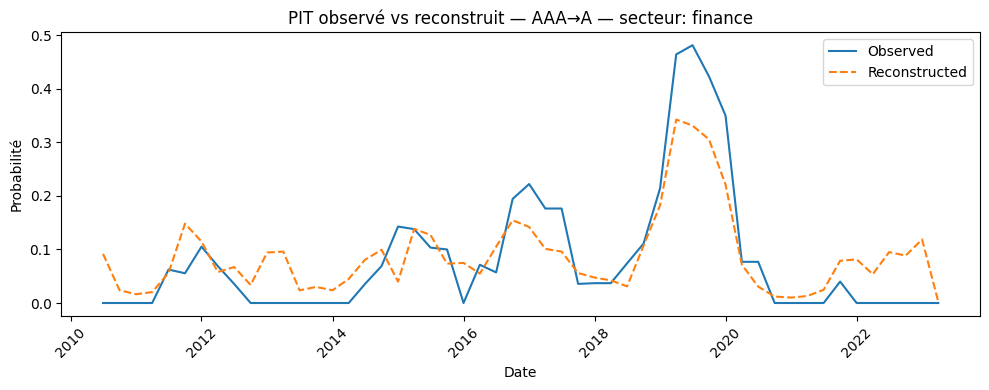

In [ ]:
import matplotlib.pyplot as plt

def plot_pit_observed_vs_reconstructed(probability_migrations, sector, rating="A", next_rating="D"):
    df = probability_migrations.copy()

    # Vérif colonnes
    required_cols = {"observed", "recalculated"}
    if not required_cols.issubset(df.columns):
        raise ValueError(f"Colonnes attendues {required_cols}, colonnes trouvées: {set(df.columns)}")

    # Vérif niveaux index
    expected_levels = {"year_quarter", "sector", "rating", "next_rating"}
    if not expected_levels.issubset(df.index.names):
        raise ValueError(f"Niveaux attendus {expected_levels}, niveaux trouvés: {df.index.names}")

    # Filtre sur secteur + rating initial
    df_sr = df.xs((sector, rating), level=("sector", "rating"))

    # df_sr index = (year_quarter, next_rating)
    # On récupère uniquement next_rating voulu
    s = df_sr.xs(next_rating, level="next_rating").sort_index()

    plt.figure(figsize=(10, 4))
    plt.plot(s.index, s["observed"].values, label="Observed")
    plt.plot(s.index, s["recalculated"].values, linestyle="--", label="Reconstructed")
    plt.title(f"PIT observé vs reconstruit — {rating}→{next_rating} — secteur: {sector}")
    plt.xlabel("Date")
    plt.ylabel("Probabilité")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Exemple
plot_pit_observed_vs_reconstructed(probability_migrations, sector="finance", rating="AAA", next_rating="A")

In [ ]:
import numpy as np
from scipy import stats

def ks_test_normality(z):
    """
    Test de Kolmogorov-Smirnov pour normalité
    """

    # estimation paramètres
    mu = np.mean(z)
    sigma = np.std(z, ddof=1)

    # test KS
    ks_stat, p_value = stats.kstest(z, 'norm', args=(mu, sigma))

    print("Test KS pour normalité")
    print(f"Statistique KS : {ks_stat:.4f}")
    print(f"p-value        : {p_value:.4f}")
    print(f"μ estimé       : {mu:.4f}")
    print(f"σ estimé       : {sigma:.4f}")

    if p_value < 0.05:
        print("→ Rejet de H0 : z_t ne suit pas une loi normale")
    else:
        print("→ Impossible de rejeter H0 : normalité plausible")

    return ks_stat, p_value

In [ ]:
ks_test_normality(zt_series)

Test KS pour normalité
Statistique KS : 0.0717
p-value        : 0.9346
μ estimé       : 0.0340
σ estimé       : 0.8708
→ Impossible de rejeter H0 : normalité plausible


(np.float64(0.07167749636329995), np.float64(0.9346035750489317))